In [342]:
import argparse
import os
from kabuki.analyze import gelman_rubin
import pandas
import hddm
import glob
import re
import pickle as pkl

path = '/home/gdholla1/projects/bias/data/hddm_fits'

# SELECT MASK


def get_model(model, hemisphere):
    df = pandas.read_pickle('/home/gdholla1/projects/bias/data/behavior/behavior_and_single_trial_estimates.pandas')

    # Prepare data
    data = df
    data['response'] = data['correct']
    data['rt'] = data['rt'] / 1000.
    data = data[(data.rt > .2) & (data.rt < 1.5)]
    data = data[~data.rt.isnull()]
    data['cue_coding'] = data.cue_validity.map({'valid':1, 'neutral':0, 'invalid':-1})

    def z_link_func(x, data=data):
        return 1 / (1 + np.exp(-(x.values.ravel())))

    if model == 'drift_super':
        z_reg = {'model': 'z ~ 0 + cue_coding', 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + cue_coding + C(difficulty)*{}_stim + C(difficulty)*{}_stim + C(difficulty)*{}_stim'.format('STh_{}_A'.format(hemisphere),
                                                                                                                 'STh_{}_B'.format(hemisphere),
                                                                                                                 'STh_{}_C'.format(hemisphere),), 
                 'link_func': lambda x: x}
        
        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv'), bias=True, group_only_regressors=False, group_only_nodes=['sv'])

    if model == 'drift_errors_super':
        z_reg = {'model': 'z ~ 0 + cue_coding', 'link_func': z_link_func}
        v_reg = {'model': ('v ~ 1 + '
                          'C(difficulty)*{}_stim + {}_stim:correct + '
                          'C(difficulty)*{}_stim + {}_stim:correct + ' 
                          'C(difficulty)*{}_stim + {}_stim:correct').format('STh_{}_A'.format(hemisphere), 'STh_{}_A'.format(hemisphere),
                                                                            'STh_{}_B'.format(hemisphere), 'STh_{}_B'.format(hemisphere),
                                                                            'STh_{}_C'.format(hemisphere), 'STh_{}_C'.format(hemisphere)), 'link_func': lambda x: x}
        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv'), bias=True, group_only_regressors=True, group_only_nodes=['sv'])

    if model == 'start_point_super':
        z_reg = {'model': 'z ~ 0 + cue_coding + cue_coding:{}_cue + cue_coding:{}_cue + cue_coding:{}_cue'.format('STh_{}_A'.format(hemisphere),
                                                                                                                  'STh_{}_B'.format(hemisphere),
                                                                                                                  'STh_{}_C'.format(hemisphere),), 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + cue_coding + C(difficulty)', 'link_func': lambda x: x}
        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv'), bias=True, group_only_regressors=False, group_only_nodes=['sv'])

    if model == 'all_super':
        z_reg = {'model': 'z ~ 0 + cue_coding + cue_coding:{}_cue + cue_coding:{}_cue + cue_coding:{}_cue'.format('STh_{}_A'.format(hemisphere),
                                                                                                                  'STh_{}_B'.format(hemisphere),
                                                                                                                  'STh_{}_C'.format(hemisphere),), 'link_func': z_link_func}
        #v_reg = {'model': ('v ~ 1 + '
                          #'C(difficulty)*{}_stim + {}_stim:correct + '
                          #'C(difficulty)*{}_stim + {}_stim:correct + ' 
                          #'C(difficulty)*{}_stim + {}_stim:correct').format('STh_{}_A'.format(hemisphere), 'STh_{}_A'.format(hemisphere),
                                                                            #'STh_{}_B'.format(hemisphere), 'STh_{}_B'.format(hemisphere),
                                                                            #'STh_{}_C'.format(hemisphere), 'STh_{}_C'.format(hemisphere)), 'link_func': lambda x: x}        
        v_reg = {'model': ('v ~ 1 + '
                          'C(difficulty)*{}_stim  + '
                          'C(difficulty)*{}_stim + ' 
                          'C(difficulty)*{}_stim').format('STh_{}_A'.format(hemisphere), 'STh_{}_B'.format(hemisphere), 'STh_{}_C'.format(hemisphere), ), 'link_func': lambda x: x}        


    if model == 'all_super_drift_bias_cue':
        z_reg = {'model': 'z ~ 0 + cue_coding + cue_coding:{}_cue + cue_coding:{}_cue + cue_coding:{}_cue'.format('STh_{}_A'.format(hemisphere),
                                                                                                                  'STh_{}_B'.format(hemisphere),
                                                                                                                  'STh_{}_C'.format(hemisphere),), 'link_func': z_link_func}
        v_reg = {'model': ('v ~ 1 + '
                          'C(difficulty)*{}_stim  +'
                          'C(difficulty)*{}_stim + ' 
                          'C(difficulty)*{}_stim + '
                          'cue_coding + cue_coding:{}_cue + cue_coding:{}_cue + cue_coding:{}_cue').format('STh_{}_A'.format(hemisphere), 'STh_{}_B'.format(hemisphere), 'STh_{}_C'.format(hemisphere), 'STh_{}_A'.format(hemisphere), 'STh_{}_B'.format(hemisphere), 'STh_{}_C'.format(hemisphere), ), 'link_func': lambda x: x}        

        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv'), bias=True, group_only_regressors=False, group_only_nodes=['sv'])

    if model == 'all_super_drift_bias_stim':
        z_reg = {'model': 'z ~ 0 + cue_coding + cue_coding:{}_cue + cue_coding:{}_cue + cue_coding:{}_cue'.format('STh_{}_A'.format(hemisphere),
                                                                                                                  'STh_{}_B'.format(hemisphere),
                                                                                                                  'STh_{}_C'.format(hemisphere),), 'link_func': z_link_func}
        v_reg = {'model': ('v ~ 1 + '
                          'C(difficulty)*{}_stim  +'
                          'C(difficulty)*{}_stim + ' 
                          'C(difficulty)*{}_stim + '
                          'cue_coding + cue_coding:{}_stim + cue_coding:{}_stim + cue_coding:{}_stim').format('STh_{}_A'.format(hemisphere), 'STh_{}_B'.format(hemisphere), 'STh_{}_C'.format(hemisphere), 'STh_{}_A'.format(hemisphere), 'STh_{}_B'.format(hemisphere), 'STh_{}_C'.format(hemisphere), ), 'link_func': lambda x: x}        


        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv'), bias=True, group_only_regressors=False, group_only_nodes=['sv'])

    if model == 'all_super_drift_bias_stim_sv_sz_p_outlier':
        z_reg = {'model': 'z ~ 0 + cue_coding + cue_coding:{}_cue + cue_coding:{}_cue + cue_coding:{}_cue'.format('STh_{}_A'.format(hemisphere),
                                                                                                                  'STh_{}_B'.format(hemisphere),
                                                                                                                  'STh_{}_C'.format(hemisphere),), 'link_func': z_link_func}
        v_reg = {'model': ('v ~ 1 + '
                          'C(difficulty)*{}_stim  +'
                          'C(difficulty)*{}_stim + ' 
                          'C(difficulty)*{}_stim + '
                          'cue_coding + cue_coding:{}_stim + cue_coding:{}_stim + cue_coding:{}_stim').format('STh_{}_A'.format(hemisphere), 'STh_{}_B'.format(hemisphere), 'STh_{}_C'.format(hemisphere), 'STh_{}_A'.format(hemisphere), 'STh_{}_B'.format(hemisphere), 'STh_{}_C'.format(hemisphere), ), 'link_func': lambda x: x}        


        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv', 'sz'), bias=True, group_only_regressors=False, group_only_nodes=['sv', 'sz'], p_outlier=0.05)

    if model == 'final_super_model_startpoint':
        z_reg = {'model': 'z ~ 0 + cue_coding + cue_coding:{}_cue + cue_coding:{}_cue + cue_coding:{}_cue'.format('STh_{}_A'.format(hemisphere),
                                                                                                                  'STh_{}_B'.format(hemisphere),
                                                                                                                  'STh_{}_C'.format(hemisphere),), 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty) + cue_coding', 'link_func': lambda x: x}        


        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv', 'sz', 'st'), bias=True, group_only_regressors=False, group_only_nodes=['sv', 'sz', 'st'])
    
    if model == 'final_super_model_drift':
        z_reg = {'model': 'z ~ 0 + cue_coding', 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty)*{}_stim + C(difficulty)*{}_stim +  C(difficulty)*{}_stim + cue_coding'.format('STh_{}_A'.format(hemisphere),
                                                                                                                               'STh_{}_B'.format(hemisphere),
                                                                                                                               'STh_{}_C'.format(hemisphere),), 'link_func': lambda x: x}        


        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv', 'sz', 'st'), bias=True, group_only_regressors=False, group_only_nodes=['sv', 'sz', 'st'])
        
        
    if model == 'final_super_model_startpoint_group':
        z_reg = {'model': 'z ~ 0 + cue_coding + cue_coding:{}_cue + cue_coding:{}_cue + cue_coding:{}_cue'.format('STh_{}_A'.format(hemisphere),
                                                                                                                  'STh_{}_B'.format(hemisphere),
                                                                                                                  'STh_{}_C'.format(hemisphere),), 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty) + cue_coding', 'link_func': lambda x: x}        


        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv', 'sz', 'st'), bias=True, group_only_regressors=True, group_only_nodes=['sv', 'sz', 'st'])


    if model == 'final_super_model_drift_group':
        z_reg = {'model': 'z ~ 0 + cue_coding', 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty)*{}_stim + C(difficulty)*{}_stim +  C(difficulty)*{}_stim + cue_coding'.format('STh_{}_A'.format(hemisphere),
                                                                                                                               'STh_{}_B'.format(hemisphere),
                                                                                                                               'STh_{}_C'.format(hemisphere),), 'link_func': lambda x: x}        


        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv', 'sz', 'st'), bias=True, group_only_regressors=True, group_only_nodes=['sv', 'sz', 'st'])

    if model == 'final_super_model_startpoint_zscored':
        
        for mask in ['STh_L_A', 'STh_L_B', 'STh_L_C', 'STh_R_A', 'STh_R_B', 'STh_R_C']:
            data['%s_cue' % mask] = data.groupby(['subj_idx', 'cue_validity'])['%s_cue' % mask].transform(lambda x: (x - x.mean())/x.std())
            data['%s_stim' % mask] = data.groupby(['subj_idx', 'cue_validity'])['%s_stim' % mask].transform(lambda x: (x - x.mean())/x.std())
            
        z_reg = {'model': 'z ~ 0 + cue_coding + cue_coding:{}_cue + cue_coding:{}_cue + cue_coding:{}_cue'.format('STh_{}_A'.format(hemisphere),
                                                                                                                  'STh_{}_B'.format(hemisphere),
                                                                                                                  'STh_{}_C'.format(hemisphere),), 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty) + cue_coding', 'link_func': lambda x: x}        


        reg_descr = [z_reg, v_reg]
        
        
        
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv', 'sz', 'st'), bias=True, group_only_regressors=False, group_only_nodes=['sv', 'sz', 'st'])        
        
        
    if model == 'final_super_model_startpoint_group_zscored':
        
        for mask in ['STh_L_A', 'STh_L_B', 'STh_L_C', 'STh_R_A', 'STh_R_B', 'STh_R_C']:
            data['%s_cue' % mask] = data.groupby(['subj_idx', 'cue_validity'])['%s_cue' % mask].transform(lambda x: (x - x.mean())/x.std())
            data['%s_stim' % mask] = data.groupby(['subj_idx', 'cue_validity'])['%s_stim' % mask].transform(lambda x: (x - x.mean())/x.std())
            
        z_reg = {'model': 'z ~ 0 + cue_coding + cue_coding:{}_cue + cue_coding:{}_cue + cue_coding:{}_cue'.format('STh_{}_A'.format(hemisphere),
                                                                                                                  'STh_{}_B'.format(hemisphere),
                                                                                                                  'STh_{}_C'.format(hemisphere),), 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty) + cue_coding', 'link_func': lambda x: x}        


        reg_descr = [z_reg, v_reg]
        
        
        
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv', 'sz', 'st'), bias=True, group_only_regressors=True, group_only_nodes=['sv', 'sz', 'st'])        
        
    if model == 'final_super_model_drift_zscored':
        
        for mask in ['STh_L_A', 'STh_L_B', 'STh_L_C', 'STh_R_A', 'STh_R_B', 'STh_R_C']:
            data['%s_cue' % mask] = data.groupby(['subj_idx', 'difficulty'])['%s_cue' % mask].transform(lambda x: (x - x.mean())/x.std())
            data['%s_stim' % mask] = data.groupby(['subj_idx', 'difficulty'])['%s_stim' % mask].transform(lambda x: (x - x.mean())/x.std())
            
        z_reg = {'model': 'z ~ 0 + cue_coding', 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty)*{}_stim + C(difficulty)*{}_stim +  C(difficulty)*{}_stim + cue_coding'.format('STh_{}_A'.format(hemisphere),
                                                                                                                               'STh_{}_B'.format(hemisphere),
                                                                                                                               'STh_{}_C'.format(hemisphere),), 'link_func': lambda x: x}        


        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv', 'sz', 'st'), bias=True, group_only_regressors=False, group_only_nodes=['sv', 'sz', 'st'])
        
    if model == 'final_super_model_drift_group_zscored':
        
        for mask in ['STh_L_A', 'STh_L_B', 'STh_L_C', 'STh_R_A', 'STh_R_B', 'STh_R_C']:
            data['%s_cue' % mask] = data.groupby(['subj_idx', 'difficulty'])['%s_cue' % mask].transform(lambda x: (x - x.mean())/x.std())
            data['%s_stim' % mask] = data.groupby(['subj_idx', 'difficulty'])['%s_stim' % mask].transform(lambda x: (x - x.mean())/x.std())
            
        z_reg = {'model': 'z ~ 0 + cue_coding', 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty)*{}_stim + C(difficulty)*{}_stim +  C(difficulty)*{}_stim + cue_coding'.format('STh_{}_A'.format(hemisphere),
                                                                                                                               'STh_{}_B'.format(hemisphere),
                                                                                                                               'STh_{}_C'.format(hemisphere),), 'link_func': lambda x: x}        


        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv', 'sz', 'st'), bias=True, group_only_regressors=True, group_only_nodes=['sv', 'sz', 'st'])


    if model == 'final_super_model_drift_zscored_error_interaction':

        for mask in ['STh_L_A', 'STh_L_B', 'STh_L_C', 'STh_R_A', 'STh_R_B', 'STh_R_C']:
            data['%s_cue' % mask] = data.groupby(['subj_idx', 'difficulty', 'response'])['%s_cue' % mask].transform(lambda x: (x - x.mean())/x.std())
            data['%s_stim' % mask] = data.groupby(['subj_idx', 'difficulty', 'response'])['%s_stim' % mask].transform(lambda x: (x - x.mean())/x.std())

        z_reg = {'model': 'z ~ 0 + cue_coding', 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty)*{}_stim + C(difficulty)*{}_stim +  C(difficulty)*{}_stim + cue_coding'.format('STh_{}_A'.format(hemisphere),
                                                                                                                               'STh_{}_B'.format(hemisphere),
                                                                                                                               'STh_{}_C'.format(hemisphere),), 'link_func': lambda x: x}


        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv', 'sz', 'st'), bias=True, group_only_regressors=False, group_only_nodes=['sv', 'sz', 'st'])

    if model == 'final_super_model_drift_group_zscored_error_interaction':

        for mask in ['STh_L_A', 'STh_L_B', 'STh_L_C', 'STh_R_A', 'STh_R_B', 'STh_R_C']:
            data['%s_cue' % mask] = data.groupby(['subj_idx', 'difficulty', 'response'])['%s_cue' % mask].transform(lambda x: (x - x.mean())/x.std())
            data['%s_stim' % mask] = data.groupby(['subj_idx', 'difficulty', 'response'])['%s_stim' % mask].transform(lambda x: (x - x.mean())/x.std())

        z_reg = {'model': 'z ~ 0 + cue_coding', 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty)*{}_stim + C(difficulty)*{}_stim +  C(difficulty)*{}_stim + cue_coding'.format('STh_{}_A'.format(hemisphere),
                                                                                                                               'STh_{}_B'.format(hemisphere),
                                                                                                                               'STh_{}_C'.format(hemisphere),), 'link_func': lambda x: x}



        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv', 'sz', 'st'), bias=True, group_only_regressors=True, group_only_nodes=['sv', 'sz', 'st'])
        
    if model.startswith('final_super_model_startpoint_group_zscored_'):

        for mask in ['STh_L_A', 'STh_L_B', 'STh_L_C', 'STh_R_A', 'STh_R_B', 'STh_R_C']:
            data['%s_cue' % mask] = data.groupby(['subj_idx', 'difficulty', 'response'])['%s_cue' % mask].transform(lambda x: (x - x.mean())/x.std())
            data['%s_stim' % mask] = data.groupby(['subj_idx', 'difficulty', 'response'])['%s_stim' % mask].transform(lambda x: (x - x.mean())/x.std())

        mask = model[-7:]

        z_reg = {'model': 'z ~ 0 + cue_coding + cue_coding:{}_cue'.format(mask), 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty) + cue_coding', 'link_func': lambda x: x}        


        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv', 'sz', 'st'), bias=True, group_only_regressors=True, group_only_nodes=['sv', 'sz', 'st'])        


    if model.startswith('final_super_model_startpoint_zscored_'):

        for mask in ['STh_L_A', 'STh_L_B', 'STh_L_C', 'STh_R_A', 'STh_R_B', 'STh_R_C']:
            data['%s_cue' % mask] = data.groupby(['subj_idx', 'difficulty', 'response'])['%s_cue' % mask].transform(lambda x: (x - x.mean())/x.std())
            data['%s_stim' % mask] = data.groupby(['subj_idx', 'difficulty', 'response'])['%s_stim' % mask].transform(lambda x: (x - x.mean())/x.std())

        mask = model[-7:]

        z_reg = {'model': 'z ~ 0 + cue_coding + cue_coding:{}_cue'.format(mask), 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty) + cue_coding', 'link_func': lambda x: x}        


        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv', 'sz', 'st'), bias=True, group_only_regressors=False, group_only_nodes=['sv', 'sz', 'st'])        

        
        
    if model.startswith('final_super_model_drift_group_zscored_'):

        for mask in ['STh_L_A', 'STh_L_B', 'STh_L_C', 'STh_R_A', 'STh_R_B', 'STh_R_C']:
            data['%s_cue' % mask] = data.groupby(['subj_idx', 'difficulty', 'response'])['%s_cue' % mask].transform(lambda x: (x - x.mean())/x.std())
            data['%s_stim' % mask] = data.groupby(['subj_idx', 'difficulty', 'response'])['%s_stim' % mask].transform(lambda x: (x - x.mean())/x.std())

        mask = model[-7:]

        z_reg = {'model': 'z ~ 0 + cue_coding', 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty)*{}_stim + cue_coding'.format(mask), 'link_func': lambda x: x}        


        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv', 'sz', 'st'), bias=True, group_only_regressors=True, group_only_nodes=['sv', 'sz', 'st'])        


    if model.startswith('final_super_model_drift_zscored_'):

        for mask in ['STh_L_A', 'STh_L_B', 'STh_L_C', 'STh_R_A', 'STh_R_B', 'STh_R_C']:
            data['%s_cue' % mask] = data.groupby(['subj_idx', 'difficulty', 'response'])['%s_cue' % mask].transform(lambda x: (x - x.mean())/x.std())
            data['%s_stim' % mask] = data.groupby(['subj_idx', 'difficulty', 'response'])['%s_stim' % mask].transform(lambda x: (x - x.mean())/x.std())

        mask = model[-7:]

        z_reg = {'model': 'z ~ 0 + cue_coding', 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty)*{}_stim + cue_coding'.format(mask), 'link_func': lambda x: x}        


        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv', 'sz', 'st'), bias=True, group_only_regressors=False, group_only_nodes=['sv', 'sz', 'st'])        

        
        
        
    # NOW FIND, LOAD, AND CONCAT TRACES
    reg = re.compile('.*/traces_{model}_{hemisphere}_[0-9]+.pkl'.format(**locals()))
    fns = [fn for fn in glob.glob('/home/gdholla1/projects/bias/data/hddm_fits/traces_{model}_{hemisphere}_*.pkl'.format(**locals())) if reg.match(fn)]

    hddm_model.load_db(fns[0], db='pickle')

    for fn in fns[1:]:
        traces = pkl.load(open(fn))    
        for node in hddm_model.get_stochastics().node:
            node.trace._trace[0] = np.concatenate([traces[str(node)][0], node.trace[:]])     

    return hddm_model
        
        
        
        
    # NOW FIND, LOAD, AND CONCAT TRACES
    reg = re.compile('.*/traces_{model}_{hemisphere}_[0-9]+.pkl'.format(**locals()))
    fns = [fn for fn in glob.glob('/home/gdholla1/projects/bias/data/hddm_fits/traces_{model}_{hemisphere}_*.pkl'.format(**locals())) if reg.match(fn)]

    hddm_model.load_db(fns[0], db='pickle')

    for fn in fns[1:]:
        traces = pkl.load(open(fn))    
        for node in hddm_model.get_stochastics().node:
            node.trace._trace[0] = np.concatenate([traces[str(node)][0], node.trace[:]])     

    return hddm_model


# Z-scored, group

# Start point

## Z-scored group, trivariate

In [343]:
results = []

for hemisphere in ['L', 'R']:
    hddm_model = get_model('final_super_model_startpoint_group_zscored', hemisphere)
    
    traces = hddm_model.get_traces()
    
    for segment in ['A', 'B', 'C']:
        tmp = pandas.DataFrame({'value':traces['z_cue_coding:STh_{hemisphere}_{segment}_cue'.format(**locals())],
                          'segment':segment,
                          'hemisphere':hemisphere})
        
        results.append(tmp)

Adding these covariates:
['z_cue_coding', 'z_cue_coding:STh_L_A_cue', 'z_cue_coding:STh_L_B_cue', 'z_cue_coding:STh_L_C_cue']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_cue_coding']
Adding these covariates:
['z_cue_coding', 'z_cue_coding:STh_R_A_cue', 'z_cue_coding:STh_R_B_cue', 'z_cue_coding:STh_R_C_cue']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_cue_coding']


In [344]:
df = pandas.concat(results, ignore_index=True)
df.groupby(['hemisphere', 'segment']).apply(lambda x: (x.value > 0).mean())

hemisphere  segment
L           A          0.819283
            B          0.548700
            C          0.504200
R           A          0.537567
            B          0.258800
            C          0.936183
dtype: float64

In [ ]:
fac = sns.FacetGrid(df, col='hemisphere')
fac.map(sns.violinplot, 'value', 'segment', palette='Set1')


fac.fig.set_size_inches(25, 6)

for ax in fac.axes.ravel():
    ax.axvline(0, c='k', ls='--')
    
fac.set_xlabels('')

# plt.xlim(-0.2, 0.2)

for ax in fac.axes.ravel():
    ax.set_xlim(-.2, .2)
    plt.savefig('/home/gdholla1/projects/bias/reports/figures/hddm_parameters_startpoint_multivariate.pdf')

In [346]:
df.groupby(['hemisphere', 'segment']).value.apply(lambda x: pc.stats.hpd(x.values))

hemisphere  segment
L           A           [-0.0389065240148, 0.110203860187]
            B           [-0.0698035021663, 0.081362034724]
            C          [-0.0742418242917, 0.0731530059796]
R           A           [-0.0673200287233, 0.072297980851]
            B           [-0.099676141286, 0.0501742918486]
            C           [-0.0164387456881, 0.131189625609]
Name: value, dtype: object

## Check colinnearity

In [347]:
df = pandas.read_pickle('/home/gdholla1/projects/bias/data/behavior/behavior_and_single_trial_estimates.pandas')

df.correct = df.correct.map({0:'error', 1:'correct'})

In [348]:
df.groupby(['subject_id', 'block']).apply(lambda x: sp.stats.pearsonr(x['STh_L_A_cue'], x['STh_L_B_cue'])[0]).mean()

0.55050329882313231

In [349]:
df.groupby(['subject_id', 'block']).apply(lambda x: sp.stats.pearsonr(x['STh_L_A_cue'], x['STh_L_C_cue'])[0]).mean()

0.49928258417303878

In [350]:
df.groupby(['subject_id', 'block']).apply(lambda x: sp.stats.pearsonr(x['STh_R_A_cue'], x['STh_R_C_cue'])[0]).mean()

0.4414220777136002

In [351]:
df.groupby(['subject_id', 'block']).apply(lambda x: sp.stats.pearsonr(x['STh_R_A_cue'], x['STh_R_B_cue'])[0]).mean()

0.44880302470417144

In [352]:
masks = ['STh_L_A', 'STh_L_B', 'STh_L_C', 'STh_L', 'STh_R_A', 'STh_R_B', 'STh_R_C', 'STh_R']

In [353]:
df.head().correct

0      error
1      error
2    correct
3      error
4    correct
Name: correct, dtype: object

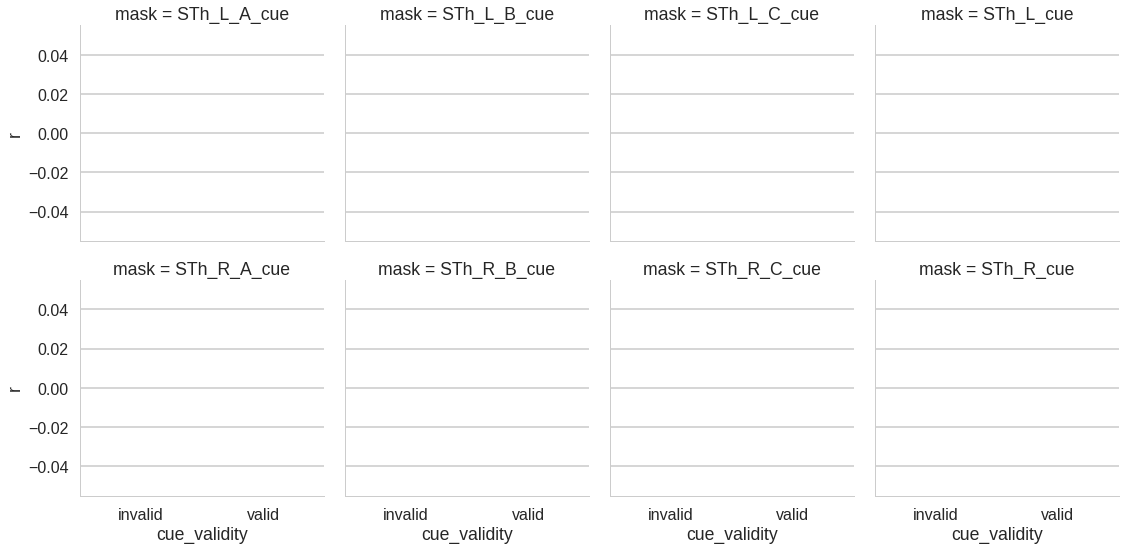

In [355]:
df = pandas.read_pickle('/home/gdholla1/projects/bias/data/behavior/behavior_and_single_trial_estimates.pandas')
df = pandas.melt(df, id_vars=['subject_id', 'block', 'cue_validity', 'rt'], var_name='mask', value_vars=['%s_cue'%mask for mask in masks])
tmp = df[~df.rt.isnull()].groupby(['subject_id', 'mask', 'cue_validity'], as_index=False).apply(lambda x: sp.stats.pearsonr(x['value'], x['rt'])[0]).to_frame('r').reset_index()

tmp['cue_validity'] = tmp.cue_validity.map({'invalid':'incongruent', 'valid':'congruent'})

fac = sns.factorplot('cue_validity', 'r', data=tmp, col='mask', col_wrap=4, kind='bar', x_order=['invalid', 'valid'])

fac.set

plt.savefig('/home/gdholla1/projects/bias/reports/figures/rt_bold_cue_correlations.pdf')

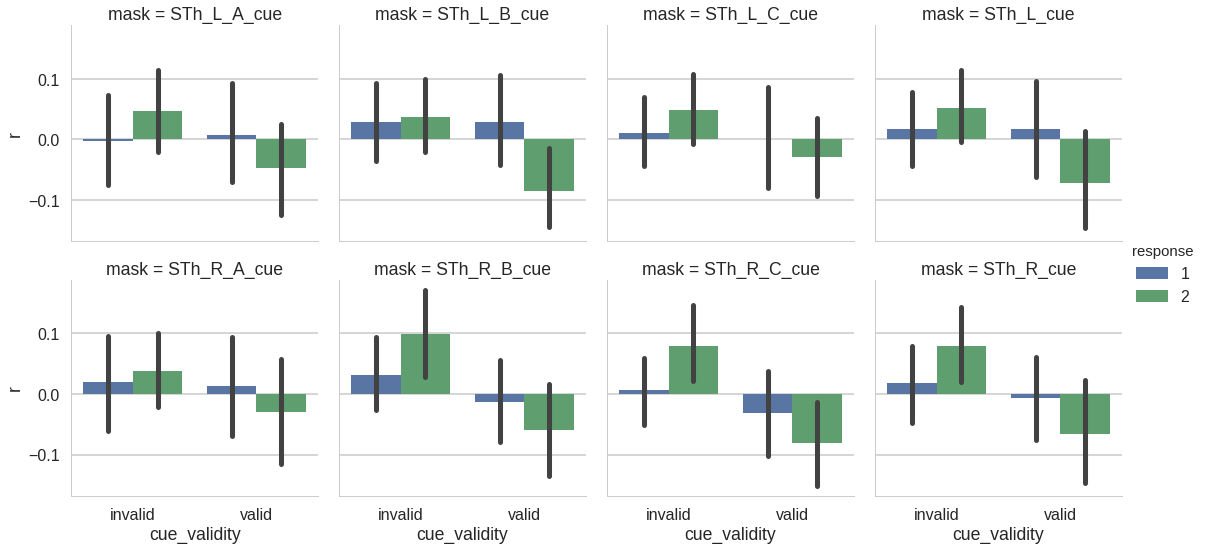

In [356]:
df = pandas.read_pickle('/home/gdholla1/projects/bias/data/behavior/behavior_and_single_trial_estimates.pandas')
df = pandas.melt(df, id_vars=['subject_id', 'block', 'cue_validity', 'rt', 'response'], var_name='mask', value_vars=['%s_cue'%mask for mask in masks])
tmp = df[~df.rt.isnull()].groupby(['subject_id', 'mask', 'cue_validity', 'response'], as_index=False).apply(lambda x: sp.stats.pearsonr(x['value'], x['rt'])[0]).to_frame('r').reset_index()

sns.factorplot('cue_validity', 'r', 'response', tmp, col='mask', col_wrap=4, kind='bar', x_order=['invalid', 'valid'])

In [357]:
df = pandas.read_pickle('/home/gdholla1/projects/bias/data/behavior/behavior_and_single_trial_estimates.pandas')
df = pandas.melt(df, id_vars=['subject_id', 'block', 'cue_validity', 'rt', 'correct'], var_name='mask', value_vars=['%s_cue'%mask for mask in masks])

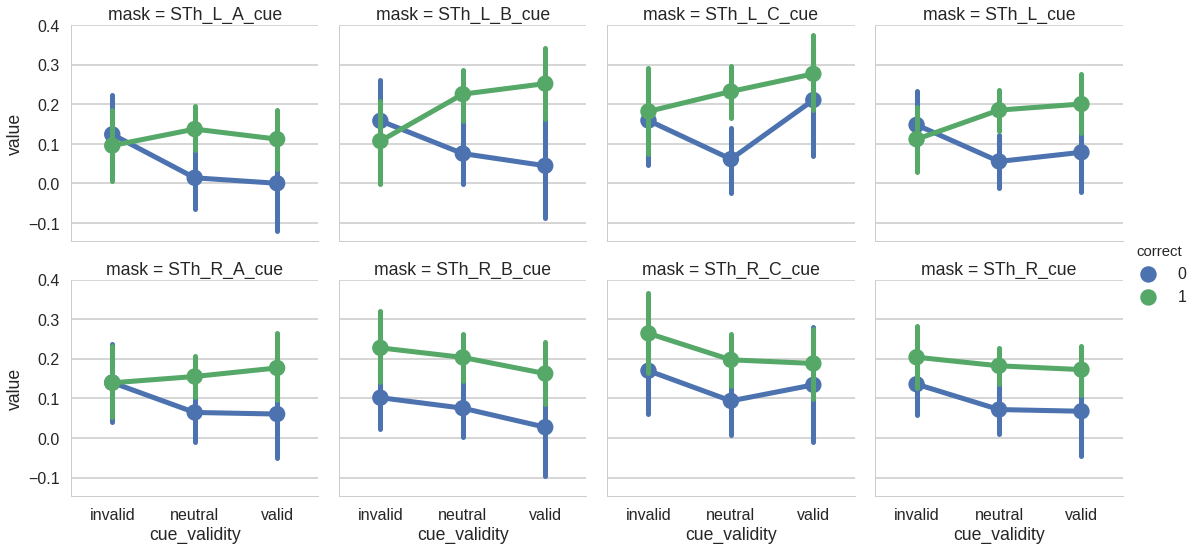

In [358]:
sns.factorplot('cue_validity', 'value', 'correct', df, col='mask', col_wrap=4, x_order=['invalid', 'neutral', 'valid'])

### Univariate

In [361]:
results = []

for hemisphere in ['L', 'R']:
    for segment in ['A', 'B', 'C']:
        
        model = get_model('final_super_model_startpoint_group_zscored_STh_%s_%s' % (hemisphere, segment), 'L')
        traces = model.get_traces()

        tmp = pandas.DataFrame({'value':traces['z_cue_coding:STh_{hemisphere}_{segment}_cue'.format(**locals())],
                          'segment':segment,
                          'hemisphere':hemisphere})
        
        results.append(tmp)

Adding these covariates:
['z_cue_coding', 'z_cue_coding:STh_L_A_cue']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_cue_coding']
Adding these covariates:
['z_cue_coding', 'z_cue_coding:STh_L_B_cue']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_cue_coding']
Adding these covariates:
['z_cue_coding', 'z_cue_coding:STh_L_C_cue']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_cue_coding']
Adding these covariates:
['z_cue_coding', 'z_cue_coding:STh_R_A_cue']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_cue_coding']
Adding these covariates:
['z_cue_coding', 'z_cue_coding:STh_R_B_cue']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_cue_coding']
Adding these covariates:
['z_cue_coding', 'z_cue_coding:STh_R_C_cue']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_cue_coding']


In [362]:
df = pandas.concat(results, ignore_index=True)
np.round(df.groupby(['hemisphere', 'segment']).apply(lambda x: (x.value > 0).mean()).to_frame('r') * 100, 1).reset_index()

,hemisphere,segment,r
0,L,A,94.3
1,L,B,89.8
2,L,C,75.6
3,R,A,82.2
4,R,B,69.9
5,R,C,90.4


In [363]:
df.groupby(['hemisphere', 'segment']).value.apply(lambda x: pc.stats.hpd(x.values)).to_frame('CI')

CI
hemisphere segment                                     
L          A         [-0.0109521085962, 0.106156243965]
           B         [-0.0197250213049, 0.097812973274]
           C        [-0.0378469869183, 0.0813668022825]
R          A        [-0.0308975594231, 0.0855807745448]
           B        [-0.0422794189114, 0.0767120230222]
           C        [-0.0185535782783, 0.0988976385886]

In [364]:
df.groupby(['hemisphere', 'segment']).value.agg([np.mean, np.std])

mean       std
hemisphere segment                    
L          A        0.046923  0.029987
           B        0.037887  0.029910
           C        0.020920  0.030323
R          A        0.027161  0.029688
           B        0.015832  0.030326
           C        0.039267  0.030085

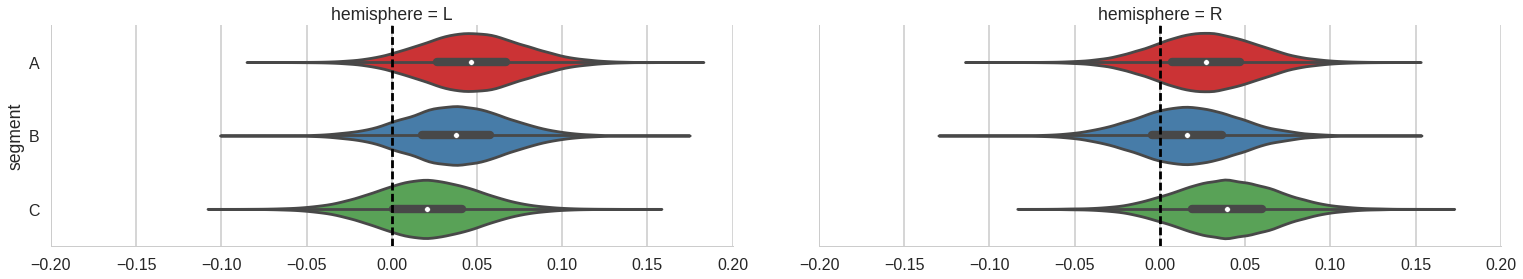

In [365]:
fac = sns.FacetGrid(df, col='hemisphere')
fac.map(sns.violinplot, 'value', 'segment', palette='Set1')


fac.fig.set_size_inches(25, 6)

for ax in fac.axes.ravel():
    ax.axvline(0, c='k', ls='--')
    
fac.set_xlabels('')

plt.xlim(-0.2, 0.2)

plt.savefig('/home/gdholla1/projects/bias/reports/figures/hddm_parameters_startpoint_univariate.pdf')

# Drift rate

## Z-scored group, univariate

In [366]:
results = []

for hemisphere in ['L', 'R']:
    for segment in ['A', 'B', 'C']:
        
        model = get_model('final_super_model_drift_group_zscored_STh_%s_%s' % (hemisphere, segment), 'L')
        traces = model.get_traces()

        tmp = pandas.DataFrame({'value':traces['v_STh_{hemisphere}_{segment}_stim'.format(**locals())],
                          'sample':traces.index,
                          'segment':segment,
                          'hemisphere':hemisphere, 
                          'difficulty':'easy'})
        
        results.append(tmp)
        
        tmp = pandas.DataFrame({'value':traces['v_STh_{hemisphere}_{segment}_stim'.format(**locals())] + traces['v_C(difficulty)[T.hard]:STh_{hemisphere}_{segment}_stim'.format(**locals())],
                  'segment':segment,
                   'sample':traces.index,                                
                  'hemisphere':hemisphere, 
                  'difficulty':'hard'})
        
        results.append(tmp)

Adding these covariates:
['z_cue_coding']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_STh_L_A_stim', 'v_C(difficulty)[T.hard]:STh_L_A_stim', 'v_cue_coding']
Adding these covariates:
['z_cue_coding']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_STh_L_B_stim', 'v_C(difficulty)[T.hard]:STh_L_B_stim', 'v_cue_coding']
Adding these covariates:
['z_cue_coding']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_STh_L_C_stim', 'v_C(difficulty)[T.hard]:STh_L_C_stim', 'v_cue_coding']
Adding these covariates:
['z_cue_coding']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_STh_R_A_stim', 'v_C(difficulty)[T.hard]:STh_R_A_stim', 'v_cue_coding']
Adding these covariates:
['z_cue_coding']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_STh_R_B_stim', 'v_C(difficulty)[T.hard]:STh_R_B_stim', 'v_cue_coding']
Adding these covariates:
['z_cue_coding']
Adding these covariates:
['v_Intercept

In [367]:
df = pandas.concat(results, ignore_index=True)
np.round(df.groupby(['difficulty', 'hemisphere', 'segment']).apply(lambda x: (x.value > 0).mean()).to_frame('r') * 100, 1).reset_index()

,difficulty,hemisphere,segment,r
0,easy,L,A,54.9
1,easy,L,B,55.5
2,easy,L,C,54.2
3,easy,R,A,41.9
4,easy,R,B,51.0
5,easy,R,C,60.1
6,hard,L,A,43.6
7,hard,L,B,35.2
8,hard,L,C,37.7
9,hard,R,A,45.2


In [368]:
df = pandas.concat(results, ignore_index=True)
np.round(df.groupby(['difficulty', 'hemisphere', 'segment']).agg([np.mean, np.std]), 2).value

mean   std
difficulty hemisphere segment            
easy       L          A        0.01  0.04
                      B        0.01  0.04
                      C        0.00  0.04
           R          A       -0.01  0.04
                      B        0.00  0.04
                      C        0.01  0.04
hard       L          A       -0.01  0.04
                      B       -0.02  0.04
                      C       -0.01  0.04
           R          A       -0.01  0.04
                      B        0.00  0.04
                      C       -0.01  0.04

In [369]:
df = pandas.concat(results, ignore_index=True)
df.groupby(['difficulty', 'hemisphere', 'segment']).value.apply(pc.stats.hpd)

difficulty  hemisphere  segment
easy        L           A          [-0.0809508859063, 0.0935299278271]
                        B          [-0.0802439957161, 0.0944743118698]
                        C          [-0.0816026911676, 0.0939352563203]
            R           A          [-0.0956758320464, 0.0775418463938]
                        B          [-0.0869097333852, 0.0884058792518]
                        C          [-0.0762001131827, 0.0973688144206]
hard        L           A          [-0.0899835151342, 0.0753119131127]
                        B           [-0.102377725018, 0.0643189498413]
                        C          [-0.0937417568568, 0.0725677873053]
            R           A          [-0.0889923515122, 0.0774620625008]
                        B          [-0.0813650310371, 0.0848946200261]
                        C          [-0.0898846546468, 0.0769035935753]
Name: value, dtype: object

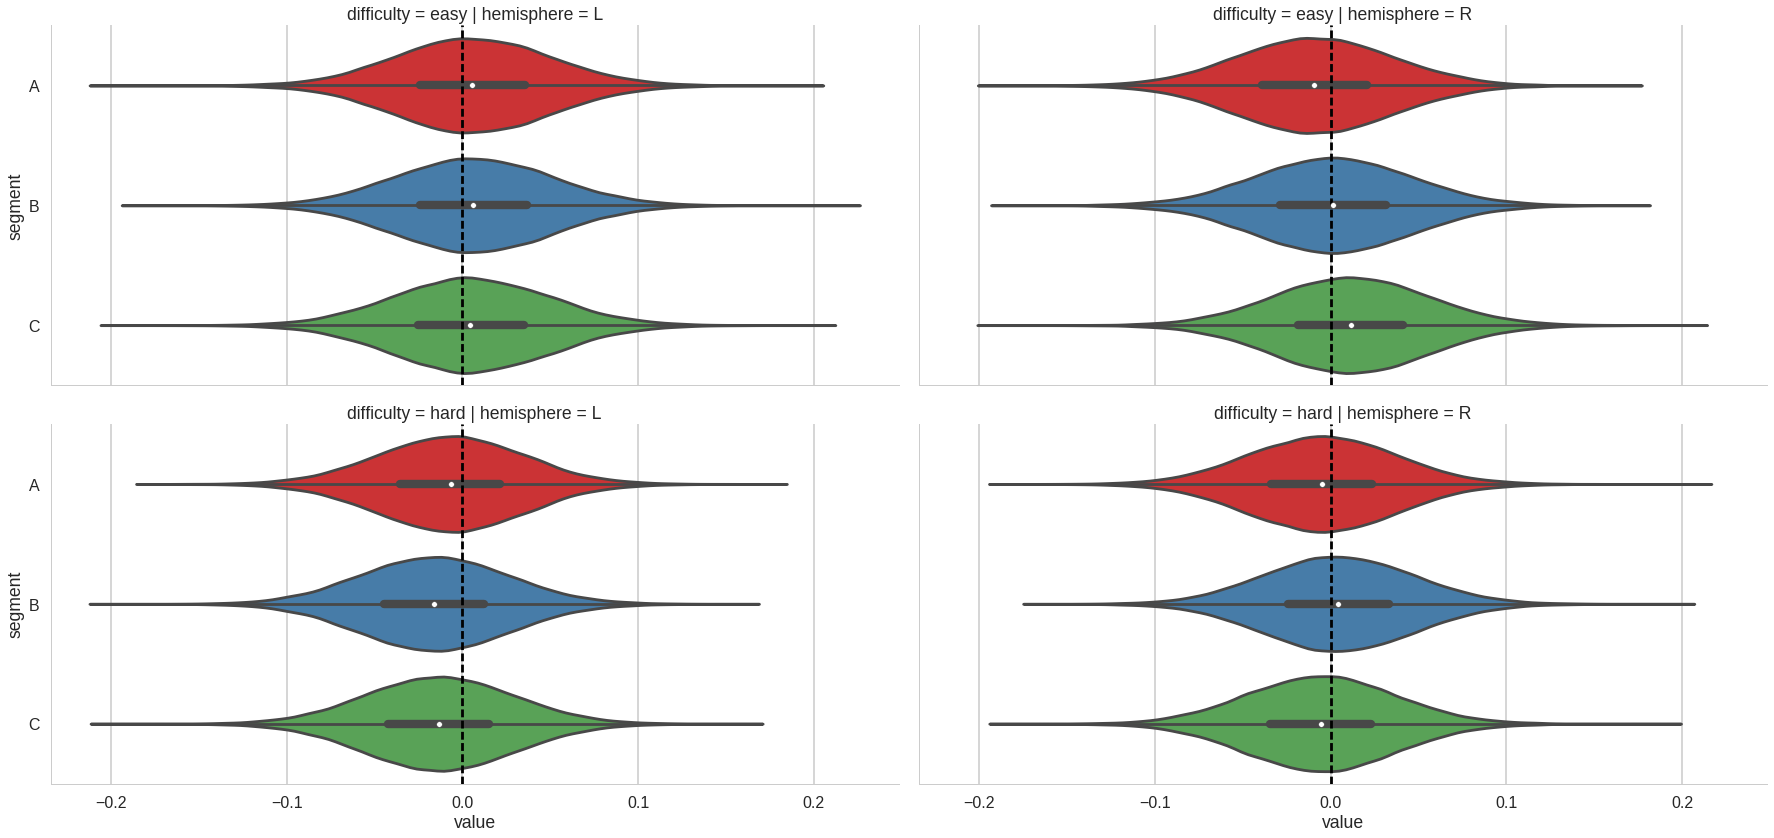

In [370]:
fac = sns.FacetGrid(df, col='hemisphere', row='difficulty')
fac.map(sns.violinplot, 'value', 'segment', palette='Set1')



for ax in fac.axes.ravel():
    ax.axvline(0, c='k', ls='--')
    
fac.fig.set_size_inches(25, 12)

plt.tight_layout()

plt.savefig('/home/gdholla1/projects/bias/reports/figures/hddm_parameters_driftrate_univariate.pdf')

In [371]:
df.head()

,difficulty,hemisphere,sample,segment,value
0,easy,L,0,A,-0.046248
1,easy,L,1,A,-0.051129
2,easy,L,2,A,-0.031224
3,easy,L,3,A,-0.039390
4,easy,L,4,A,-0.075258


In [372]:
df.groupby(['hemisphere', 'segment', 'difficulty']).value.apply(lambda x: pc.stats.hpd(x.values))

hemisphere  segment  difficulty
L           A        easy          [-0.0809508859063, 0.0935299278271]
                     hard          [-0.0899835151342, 0.0753119131127]
            B        easy          [-0.0802439957161, 0.0944743118698]
                     hard           [-0.102377725018, 0.0643189498413]
            C        easy          [-0.0816026911676, 0.0939352563203]
                     hard          [-0.0937417568568, 0.0725677873053]
R           A        easy          [-0.0956758320464, 0.0775418463938]
                     hard          [-0.0889923515122, 0.0774620625008]
            B        easy          [-0.0869097333852, 0.0884058792518]
                     hard          [-0.0813650310371, 0.0848946200261]
            C        easy          [-0.0762001131827, 0.0973688144206]
                     hard          [-0.0898846546468, 0.0769035935753]
Name: value, dtype: object

# Start point

## Hierarchical

In [309]:
results = []

for hemisphere in ['L', 'R']:
    hddm_model = get_model('final_super_model_startpoint', hemisphere)
    
    traces = hddm_model.get_traces()
    
    for segment in ['A', 'B', 'C']:
        tmp = pandas.DataFrame({'value':traces['z_cue_coding:STh_{hemisphere}_{segment}_cue'.format(**locals())],
                          'segment':segment,
                          'hemisphere':hemisphere})
        
        results.append(tmp)

Adding these covariates:
['z_cue_coding', 'z_cue_coding:STh_L_A_cue', 'z_cue_coding:STh_L_B_cue', 'z_cue_coding:STh_L_C_cue']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_cue_coding']
Adding these covariates:
['z_cue_coding', 'z_cue_coding:STh_R_A_cue', 'z_cue_coding:STh_R_B_cue', 'z_cue_coding:STh_R_C_cue']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_cue_coding']


In [310]:
df = pandas.concat(results, ignore_index=True)

In [311]:
df.groupby(['hemisphere', 'segment']).apply(lambda x: (x.value > 0).mean())

hemisphere  segment
L           A          0.717083
            B          0.617617
            C          0.665900
R           A          0.748217
            B          0.203233
            C          0.941550
dtype: float64

In [312]:
sns.set_context('poster')
sns.set_style('whitegrid')

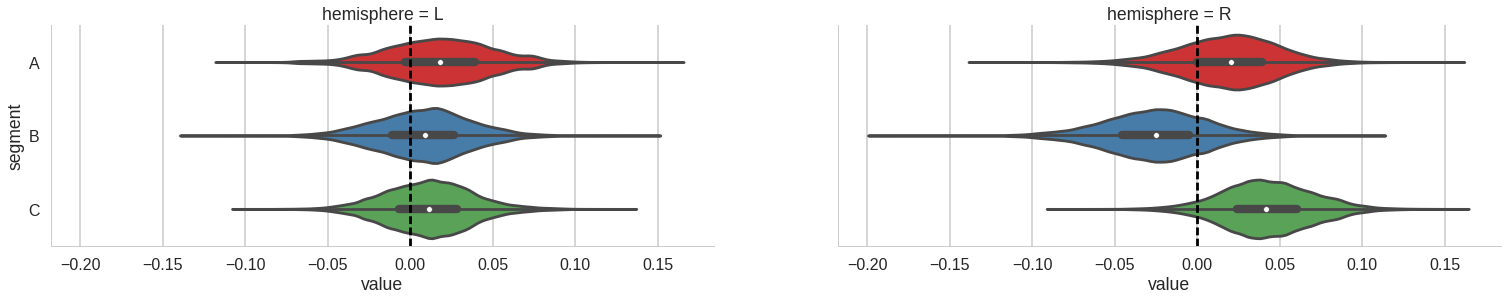

In [313]:
fac = sns.FacetGrid(df, col='hemisphere')
fac.map(sns.violinplot, 'value', 'segment', palette='Set1')


fac.fig.set_size_inches(25, 6)

for ax in fac.axes.ravel():
    ax.axvline(0, c='k', ls='--')

## Start point Group model

Adding these covariates:
['z_cue_coding', 'z_cue_coding:STh_L_A_cue', 'z_cue_coding:STh_L_B_cue', 'z_cue_coding:STh_L_C_cue']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_cue_coding']
Adding these covariates:
['z_cue_coding', 'z_cue_coding:STh_R_A_cue', 'z_cue_coding:STh_R_B_cue', 'z_cue_coding:STh_R_C_cue']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_cue_coding']


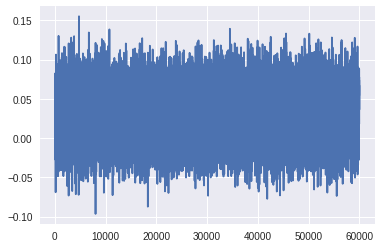

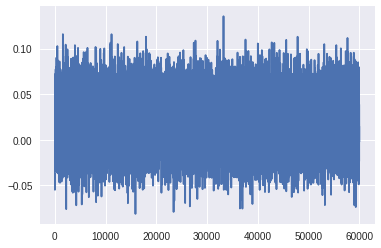

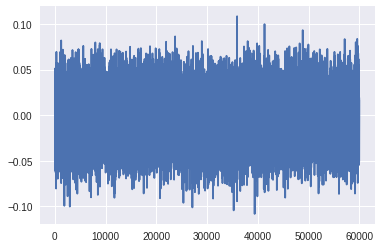

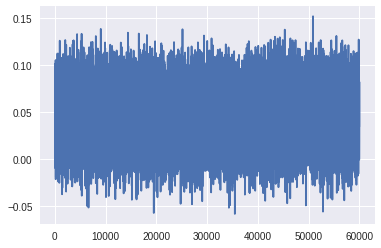

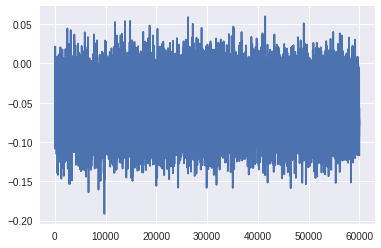

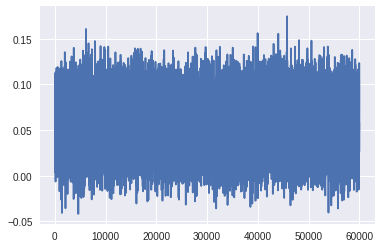

In [22]:
results = []

for hemisphere in ['L', 'R']:
    hddm_model = get_model('final_super_model_startpoint_group', hemisphere)
    
    traces = hddm_model.get_traces()
    
    for segment in ['A', 'B', 'C']:
        tmp = pandas.DataFrame({'value':traces['z_cue_coding:STh_{hemisphere}_{segment}_cue'.format(**locals())],
                          'segment':segment,
                          'hemisphere':hemisphere})
        
        results.append(tmp)
        
        plt.figure()
        plt.plot(tmp['value'])

In [23]:
df = pandas.concat(results, ignore_index=True)
df.groupby(['hemisphere', 'segment']).apply(lambda x: (x.value > 0).mean())


hemisphere  segment
L           A          0.845617
            B          0.787767
            C          0.446600
R           A          0.964467
            B          0.021783
            C          0.985450
dtype: float64

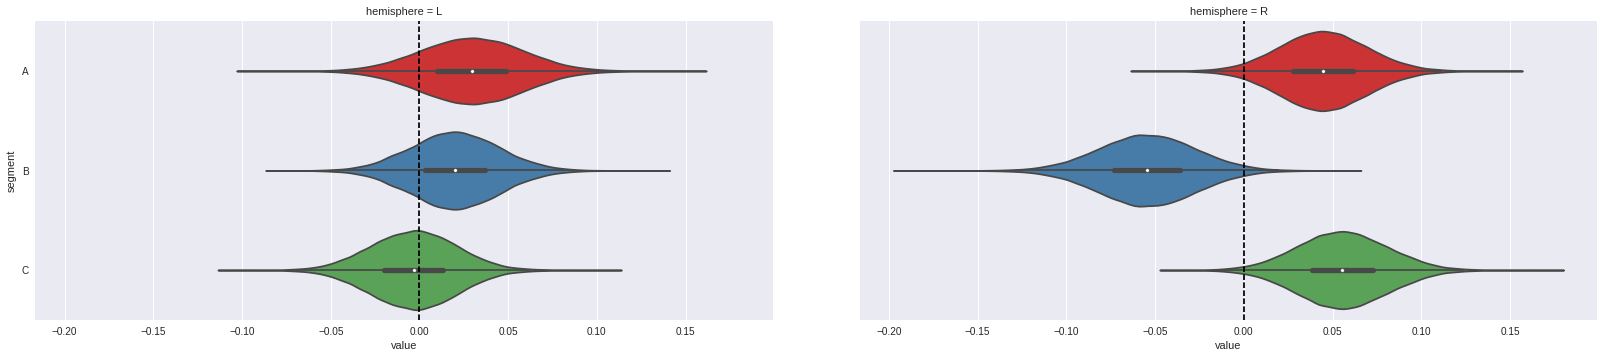

In [24]:
fac = sns.FacetGrid(df, col='hemisphere')
fac.map(sns.violinplot, 'value', 'segment', palette='Set1')


fac.fig.set_size_inches(25, 6)

for ax in fac.axes.ravel():
    ax.axvline(0, c='k', ls='--')

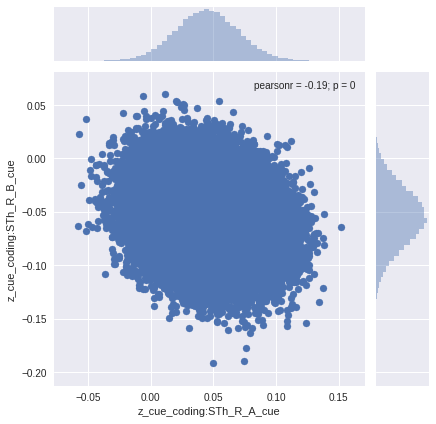

In [30]:
sns.jointplot(traces['z_cue_coding:STh_R_A_cue'], traces['z_cue_coding:STh_R_B_cue'])

In [31]:
results = []

for hemisphere in ['L', 'R']:
    hddm_model = get_model('final_super_model_startpoint_group_zscored', hemisphere)
    
    traces = hddm_model.get_traces()
    
    for segment in ['A', 'B', 'C']:
        tmp = pandas.DataFrame({'value':traces['z_cue_coding:STh_{hemisphere}_{segment}_cue'.format(**locals())],
                          'segment':segment,
                          'hemisphere':hemisphere})
        
        results.append(tmp)

Adding these covariates:
['z_cue_coding', 'z_cue_coding:STh_L_A_cue', 'z_cue_coding:STh_L_B_cue', 'z_cue_coding:STh_L_C_cue']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_cue_coding']
Adding these covariates:
['z_cue_coding', 'z_cue_coding:STh_R_A_cue', 'z_cue_coding:STh_R_B_cue', 'z_cue_coding:STh_R_C_cue']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_cue_coding']


In [33]:
df = pandas.concat(results, ignore_index=True)
df.groupby(['hemisphere', 'segment']).apply(lambda x: (x.value > 0).mean())

hemisphere  segment
L           A          0.823350
            B          0.475883
            C          0.591633
R           A          0.718283
            B          0.121117
            C          0.962300
dtype: float64

In [37]:
sns.set_context('poster')
sns.set_style('whitegrid')

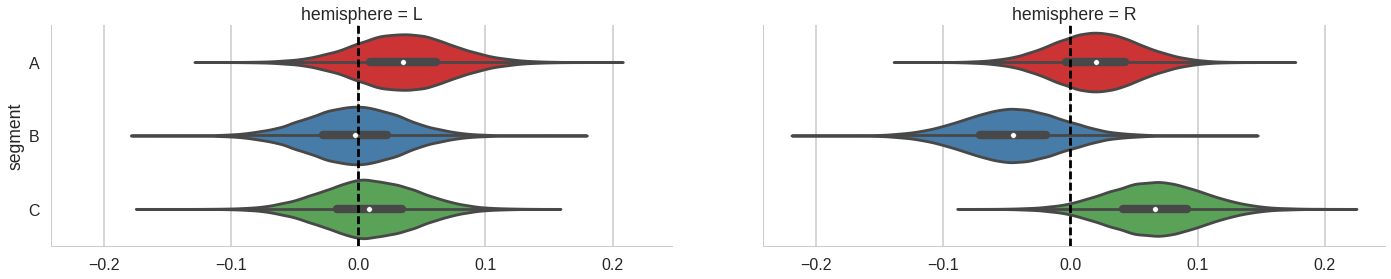

In [41]:
fac = sns.FacetGrid(df, col='hemisphere')
fac.map(sns.violinplot, 'value', 'segment', palette='Set1')


fac.fig.set_size_inches(23, 6)

for ax in fac.axes.ravel():
    ax.axvline(0, c='k', ls='--')
    
fac.set_xlabels('')

plt.savefig()

# Drift

In [302]:
results = []

for hemisphere in ['L', 'R']:
    hddm_model = get_model('final_super_model_drift', hemisphere)
    
    traces = hddm_model.get_traces()
    
    for segment in ['A', 'B', 'C']:
        tmp = pandas.DataFrame({'value':traces['v_STh_{hemisphere}_{segment}_stim'.format(**locals())],
                          'segment':segment,
                          'hemisphere':hemisphere, 
                          'difficulty':'easy'})
        
        results.append(tmp)
        
        tmp = pandas.DataFrame({'value':traces['v_STh_{hemisphere}_{segment}_stim'.format(**locals())] + traces['v_C(difficulty)[T.hard]:STh_{hemisphere}_{segment}_stim'.format(**locals())],
                  'segment':segment,
                  'hemisphere':hemisphere, 
                  'difficulty':'hard'})
        
        results.append(tmp)

Adding these covariates:
['z_cue_coding']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_STh_L_A_stim', 'v_C(difficulty)[T.hard]:STh_L_A_stim', 'v_STh_L_B_stim', 'v_C(difficulty)[T.hard]:STh_L_B_stim', 'v_STh_L_C_stim', 'v_C(difficulty)[T.hard]:STh_L_C_stim', 'v_cue_coding']
Adding these covariates:
['z_cue_coding']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_STh_R_A_stim', 'v_C(difficulty)[T.hard]:STh_R_A_stim', 'v_STh_R_B_stim', 'v_C(difficulty)[T.hard]:STh_R_B_stim', 'v_STh_R_C_stim', 'v_C(difficulty)[T.hard]:STh_R_C_stim', 'v_cue_coding']


In [303]:
df = pandas.concat(results, ignore_index=True)
df.groupby(['hemisphere', 'segment', 'difficulty']).apply(lambda x: (x.value > 0).mean())

hemisphere  segment  difficulty
L           A        easy          0.216167
                     hard          0.536483
            B        easy          0.660200
                     hard          0.708867
            C        easy          0.980017
                     hard          0.454233
R           A        easy          0.061617
                     hard          0.867250
            B        easy          0.922867
                     hard          0.539400
            C        easy          0.790600
                     hard          0.763133
dtype: float64

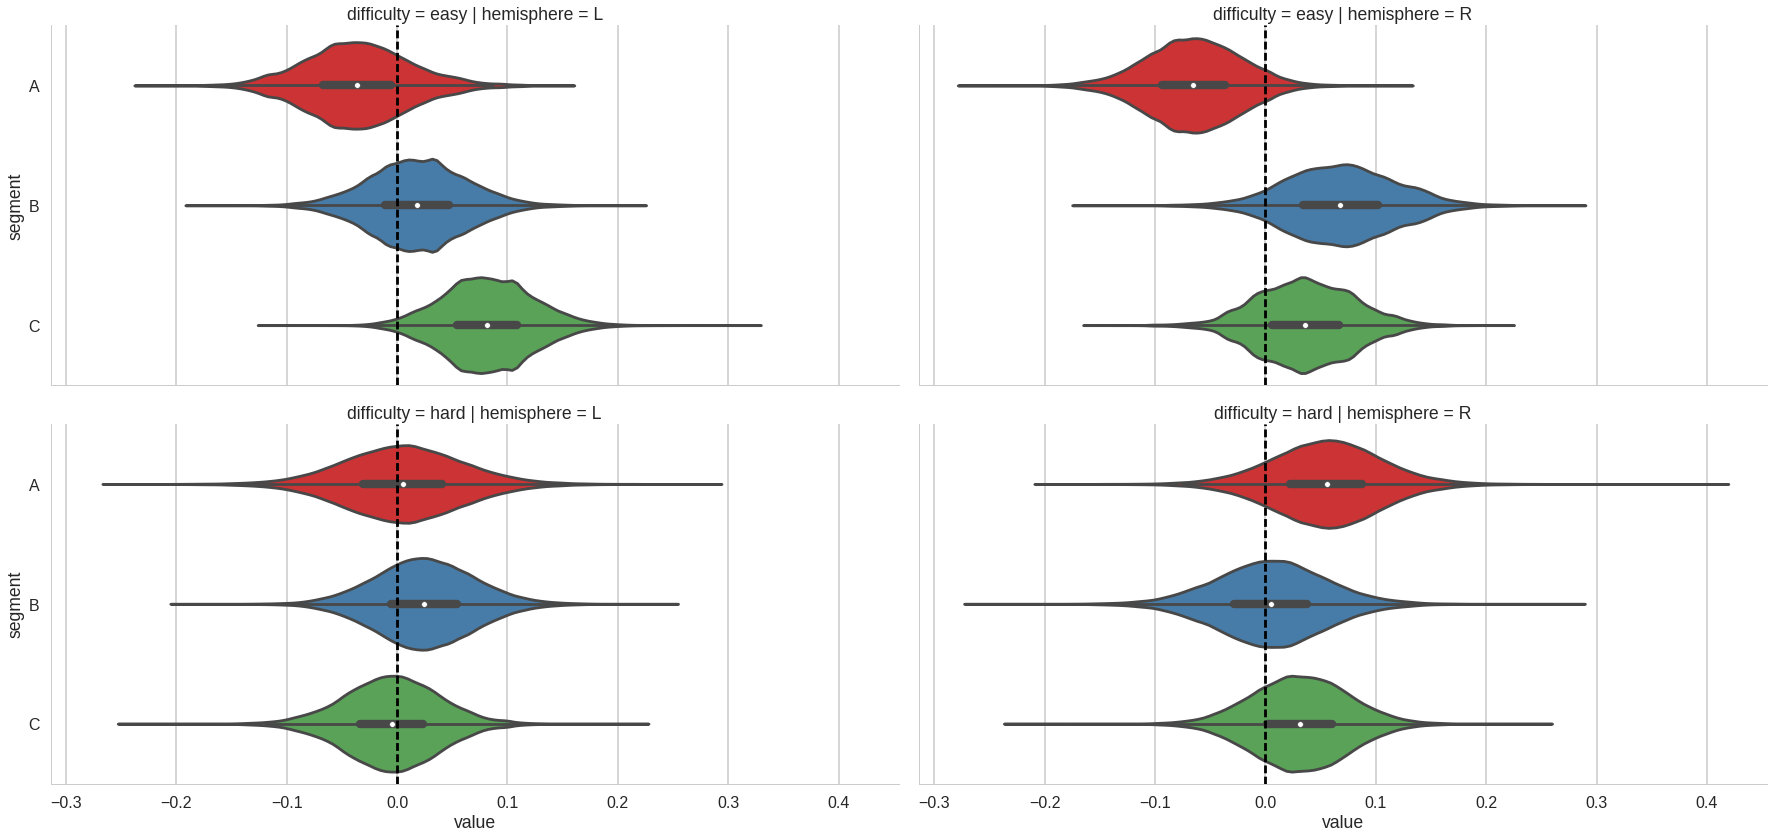

In [304]:
fac = sns.FacetGrid(df, col='hemisphere', row='difficulty')
fac.map(sns.violinplot, 'value', 'segment', palette='Set1')



for ax in fac.axes.ravel():
    ax.axvline(0, c='k', ls='--')
    
fac.fig.set_size_inches(25, 12)

plt.tight_layout()

# Drift group model

In [3]:
results = []

# for hemisphere in ['L', 'R']:
for hemisphere in ['L', 'R']:
    hddm_model = get_model('final_super_model_drift_group', hemisphere)
    
    traces = hddm_model.get_traces()
    
    for segment in ['A', 'B', 'C']:
        tmp = pandas.DataFrame({'value':traces['v_STh_{hemisphere}_{segment}_stim'.format(**locals())],
                          'sample':traces.index,
                          'segment':segment,
                          'hemisphere':hemisphere, 
                          'difficulty':'easy'})
        
        results.append(tmp)
        
        tmp = pandas.DataFrame({'value':traces['v_STh_{hemisphere}_{segment}_stim'.format(**locals())] + traces['v_C(difficulty)[T.hard]:STh_{hemisphere}_{segment}_stim'.format(**locals())],
                  'segment':segment,
                   'sample':traces.index,                                
                  'hemisphere':hemisphere, 
                  'difficulty':'hard'})
        
        results.append(tmp)

Adding these covariates:
['z_cue_coding']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_STh_L_A_stim', 'v_C(difficulty)[T.hard]:STh_L_A_stim', 'v_STh_L_B_stim', 'v_C(difficulty)[T.hard]:STh_L_B_stim', 'v_STh_L_C_stim', 'v_C(difficulty)[T.hard]:STh_L_C_stim', 'v_cue_coding']
Adding these covariates:
['z_cue_coding']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_STh_R_A_stim', 'v_C(difficulty)[T.hard]:STh_R_A_stim', 'v_STh_R_B_stim', 'v_C(difficulty)[T.hard]:STh_R_B_stim', 'v_STh_R_C_stim', 'v_C(difficulty)[T.hard]:STh_R_C_stim', 'v_cue_coding']


In [306]:
df = pandas.concat(results, ignore_index=True)
df.groupby(['hemisphere', 'difficulty', 'segment']).apply(lambda x: (x.value > 0).mean())

hemisphere  difficulty  segment
L           easy        A          0.088467
                        B          0.722883
                        C          0.987283
            hard        A          0.654033
                        B          0.576033
                        C          0.326567
R           easy        A          0.033367
                        B          0.961850
                        C          0.764500
            hard        A          0.952850
                        B          0.475483
                        C          0.645983
dtype: float64

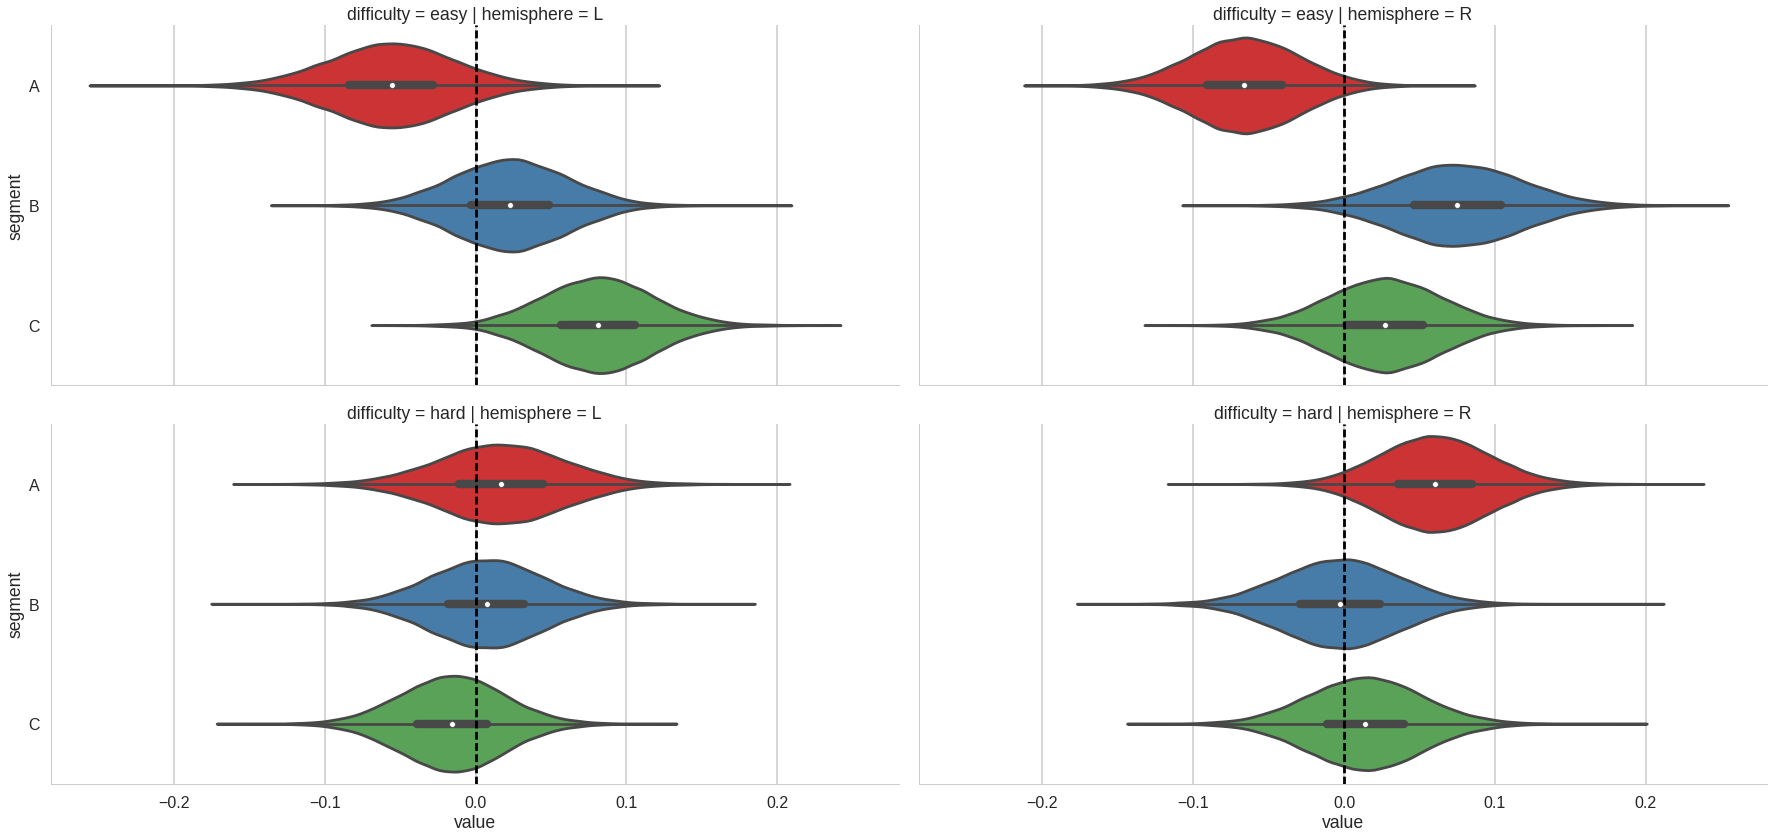

In [307]:
fac = sns.FacetGrid(df, col='hemisphere', row='difficulty')
fac.map(sns.violinplot, 'value', 'segment', palette='Set1')




for ax in fac.axes.ravel():
    ax.axvline(0, c='k', ls='--')
    

fac.fig.set_size_inches(25, 12)

plt.tight_layout()

## Drift, z-scored, group

In [4]:
results = []

for hemisphere in ['L', 'R']:
# for hemisphere in ['L']:
    hddm_model = get_model('final_super_model_drift_group_zscored', hemisphere)
    
    traces = hddm_model.get_traces()
    
    for segment in ['A', 'B', 'C']:
        tmp = pandas.DataFrame({'value':traces['v_STh_{hemisphere}_{segment}_stim'.format(**locals())],
                          'sample':traces.index,
                          'segment':segment,
                          'hemisphere':hemisphere, 
                          'difficulty':'easy'})
        
        results.append(tmp)
        
        tmp = pandas.DataFrame({'value':traces['v_STh_{hemisphere}_{segment}_stim'.format(**locals())] + traces['v_C(difficulty)[T.hard]:STh_{hemisphere}_{segment}_stim'.format(**locals())],
                  'segment':segment,
                   'sample':traces.index,                                
                  'hemisphere':hemisphere, 
                  'difficulty':'hard'})
        
        results.append(tmp)

Adding these covariates:
['z_cue_coding']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_STh_L_A_stim', 'v_C(difficulty)[T.hard]:STh_L_A_stim', 'v_STh_L_B_stim', 'v_C(difficulty)[T.hard]:STh_L_B_stim', 'v_STh_L_C_stim', 'v_C(difficulty)[T.hard]:STh_L_C_stim', 'v_cue_coding']
Adding these covariates:
['z_cue_coding']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_STh_R_A_stim', 'v_C(difficulty)[T.hard]:STh_R_A_stim', 'v_STh_R_B_stim', 'v_C(difficulty)[T.hard]:STh_R_B_stim', 'v_STh_R_C_stim', 'v_C(difficulty)[T.hard]:STh_R_C_stim', 'v_cue_coding']


In [8]:
df = pandas.concat(results, ignore_index=True)
df.groupby(['hemisphere', 'difficulty', 'segment']).apply(lambda x: (x.value > 0).mean())

hemisphere  difficulty  segment
L           easy        A          0.117367
                        B          0.680850
                        C          0.994450
            hard        A          0.669367
                        B          0.606833
                        C          0.462817
R           easy        A          0.028967
                        B          0.969583
                        C          0.756817
            hard        A          0.853200
                        B          0.673717
                        C          0.690683
dtype: float64

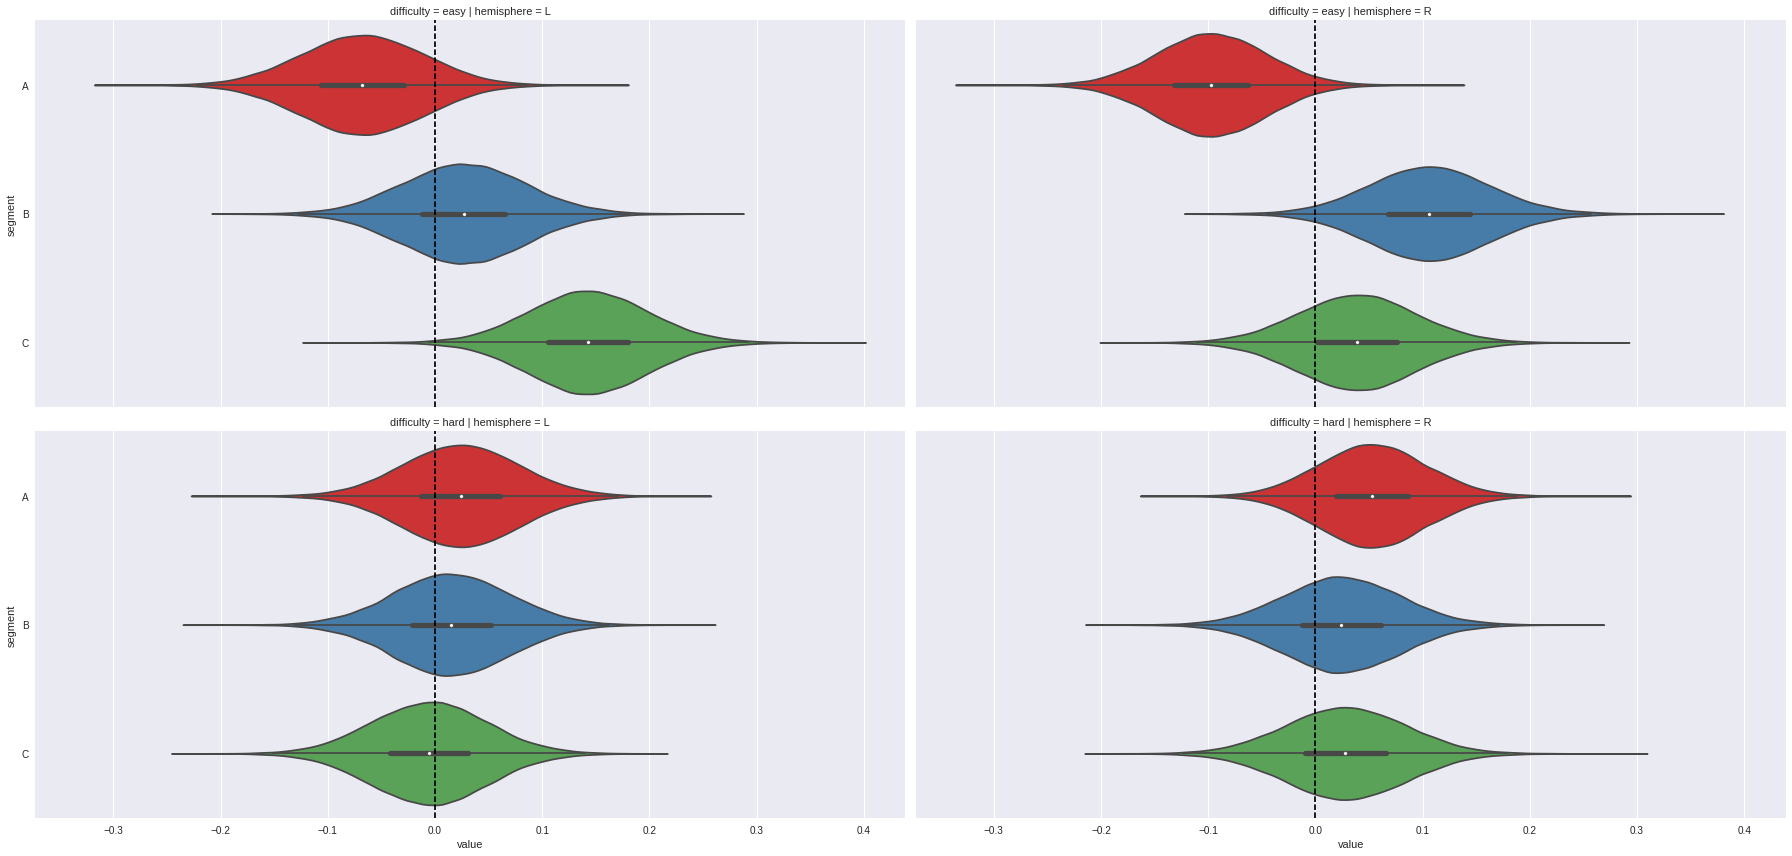

In [9]:
fac = sns.FacetGrid(df, col='hemisphere', row='difficulty')
fac.map(sns.violinplot, 'value', 'segment', palette='Set1')

for ax in fac.axes.ravel():
    ax.axvline(0, c='k', ls='--')
    

fac.fig.set_size_inches(25, 12)

plt.tight_layout()

In [11]:
results = []

for hemisphere in ['L', 'R']:
# for hemisphere in ['L']:
    hddm_model = get_model('final_super_model_drift_zscored', hemisphere)
    
    traces = hddm_model.get_traces()
    
    for segment in ['A', 'B', 'C']:
        tmp = pandas.DataFrame({'value':traces['v_STh_{hemisphere}_{segment}_stim'.format(**locals())],
                          'sample':traces.index,
                          'segment':segment,
                          'hemisphere':hemisphere, 
                          'difficulty':'easy'})
        
        results.append(tmp)
        
        tmp = pandas.DataFrame({'value':traces['v_STh_{hemisphere}_{segment}_stim'.format(**locals())] + traces['v_C(difficulty)[T.hard]:STh_{hemisphere}_{segment}_stim'.format(**locals())],
                  'segment':segment,
                   'sample':traces.index,                                
                  'hemisphere':hemisphere, 
                  'difficulty':'hard'})
        
        results.append(tmp)

Adding these covariates:
['z_cue_coding']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_STh_L_A_stim', 'v_C(difficulty)[T.hard]:STh_L_A_stim', 'v_STh_L_B_stim', 'v_C(difficulty)[T.hard]:STh_L_B_stim', 'v_STh_L_C_stim', 'v_C(difficulty)[T.hard]:STh_L_C_stim', 'v_cue_coding']
Adding these covariates:
['z_cue_coding']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_STh_R_A_stim', 'v_C(difficulty)[T.hard]:STh_R_A_stim', 'v_STh_R_B_stim', 'v_C(difficulty)[T.hard]:STh_R_B_stim', 'v_STh_R_C_stim', 'v_C(difficulty)[T.hard]:STh_R_C_stim', 'v_cue_coding']


In [12]:
df = pandas.concat(results, ignore_index=True)
df.groupby(['hemisphere', 'difficulty', 'segment']).apply(lambda x: (x.value > 0).mean())

hemisphere  difficulty  segment
L           easy        A          0.152017
                        B          0.620233
                        C          0.994983
            hard        A          0.579933
                        B          0.705850
                        C          0.414200
R           easy        A          0.030100
                        B          0.965950
                        C          0.795850
            hard        A          0.857000
                        B          0.587950
                        C          0.739250
dtype: float64

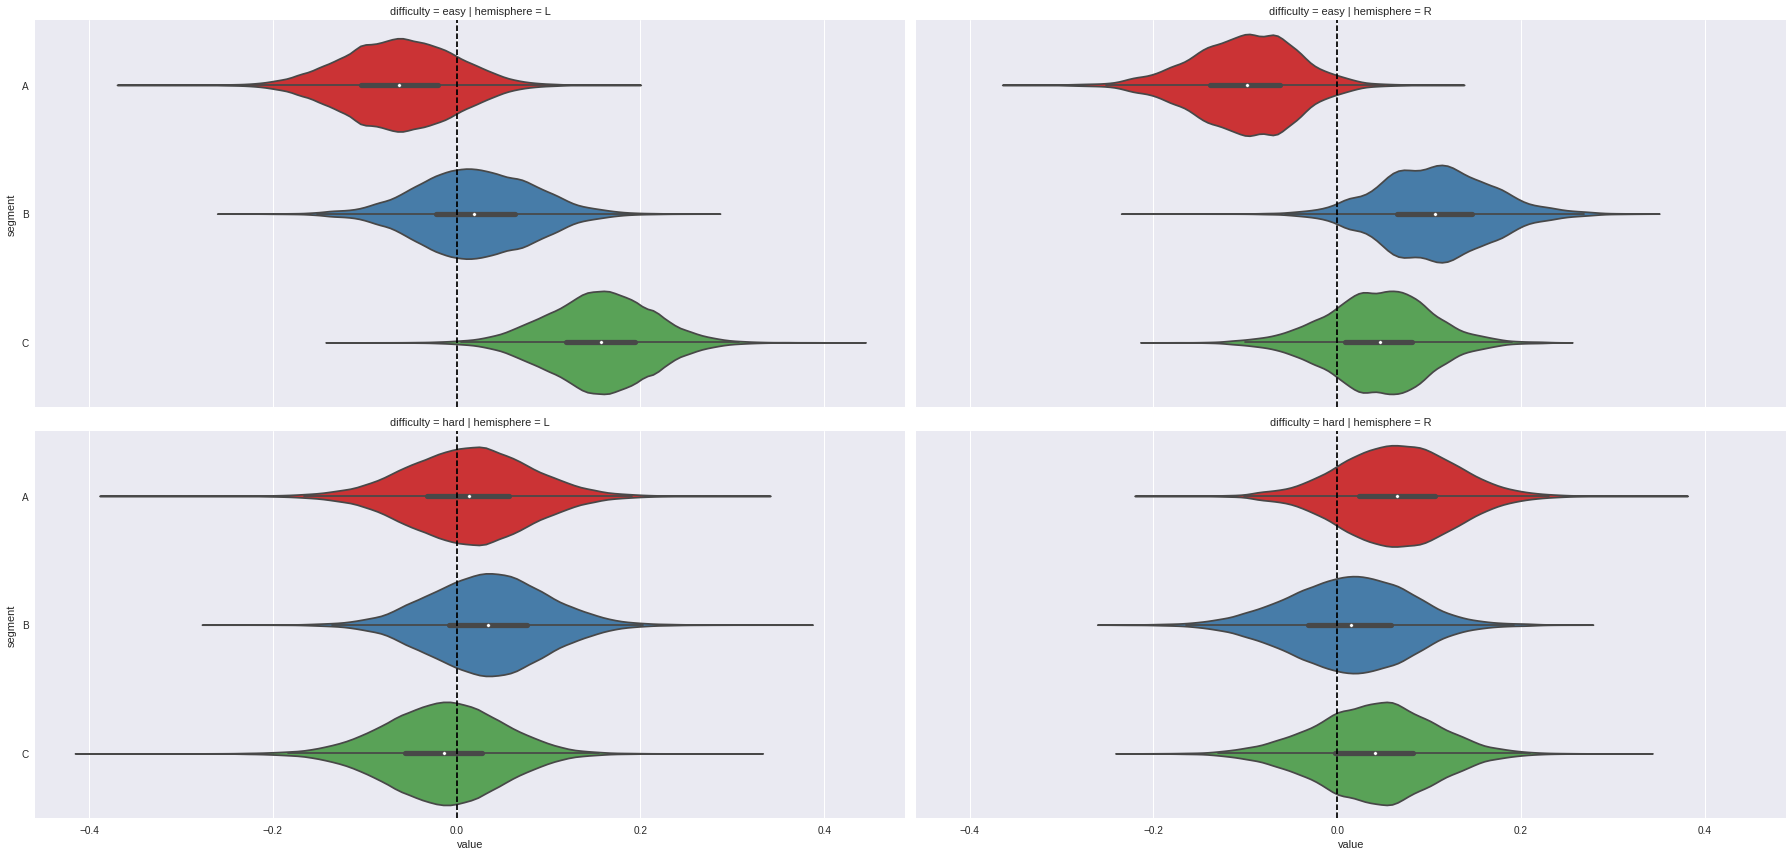

In [13]:
fac = sns.FacetGrid(df, col='hemisphere', row='difficulty')
fac.map(sns.violinplot, 'value', 'segment', palette='Set1')

for ax in fac.axes.ravel():
    ax.axvline(0, c='k', ls='--')
    

fac.fig.set_size_inches(25, 12)

plt.tight_layout()

# Drift with errors

In [16]:
results = []

for hemisphere in ['L', 'R']:
# for hemisphere in ['L']:
    hddm_model = get_model('final_super_model_drift_group_zscored_error_interaction', hemisphere)
    
    traces = hddm_model.get_traces()
    
    for segment in ['A', 'B', 'C']:
        tmp = pandas.DataFrame({'value':traces['v_STh_{hemisphere}_{segment}_stim'.format(**locals())],
                          'sample':traces.index,
                          'segment':segment,
                          'hemisphere':hemisphere, 
                          'difficulty':'easy'})
        
        results.append(tmp)
        
        tmp = pandas.DataFrame({'value':traces['v_STh_{hemisphere}_{segment}_stim'.format(**locals())] + traces['v_C(difficulty)[T.hard]:STh_{hemisphere}_{segment}_stim'.format(**locals())],
                  'segment':segment,
                   'sample':traces.index,                                
                  'hemisphere':hemisphere, 
                  'difficulty':'hard'})
        
        results.append(tmp)

Adding these covariates:
['z_cue_coding']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_STh_L_A_stim', 'v_C(difficulty)[T.hard]:STh_L_A_stim', 'v_STh_L_B_stim', 'v_C(difficulty)[T.hard]:STh_L_B_stim', 'v_STh_L_C_stim', 'v_C(difficulty)[T.hard]:STh_L_C_stim', 'v_cue_coding']
Adding these covariates:
['z_cue_coding']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_STh_R_A_stim', 'v_C(difficulty)[T.hard]:STh_R_A_stim', 'v_STh_R_B_stim', 'v_C(difficulty)[T.hard]:STh_R_B_stim', 'v_STh_R_C_stim', 'v_C(difficulty)[T.hard]:STh_R_C_stim', 'v_cue_coding']


In [17]:
df = pandas.concat(results, ignore_index=True)
df.groupby(['hemisphere', 'difficulty', 'segment']).apply(lambda x: (x.value > 0).mean())

hemisphere  difficulty  segment
L           easy        A          0.528367
                        B          0.529183
                        C          0.498250
            hard        A          0.537033
                        B          0.394650
                        C          0.441617
R           easy        A          0.378017
                        B          0.541683
                        C          0.657967
            hard        A          0.430250
                        B          0.636833
                        C          0.447733
dtype: float64

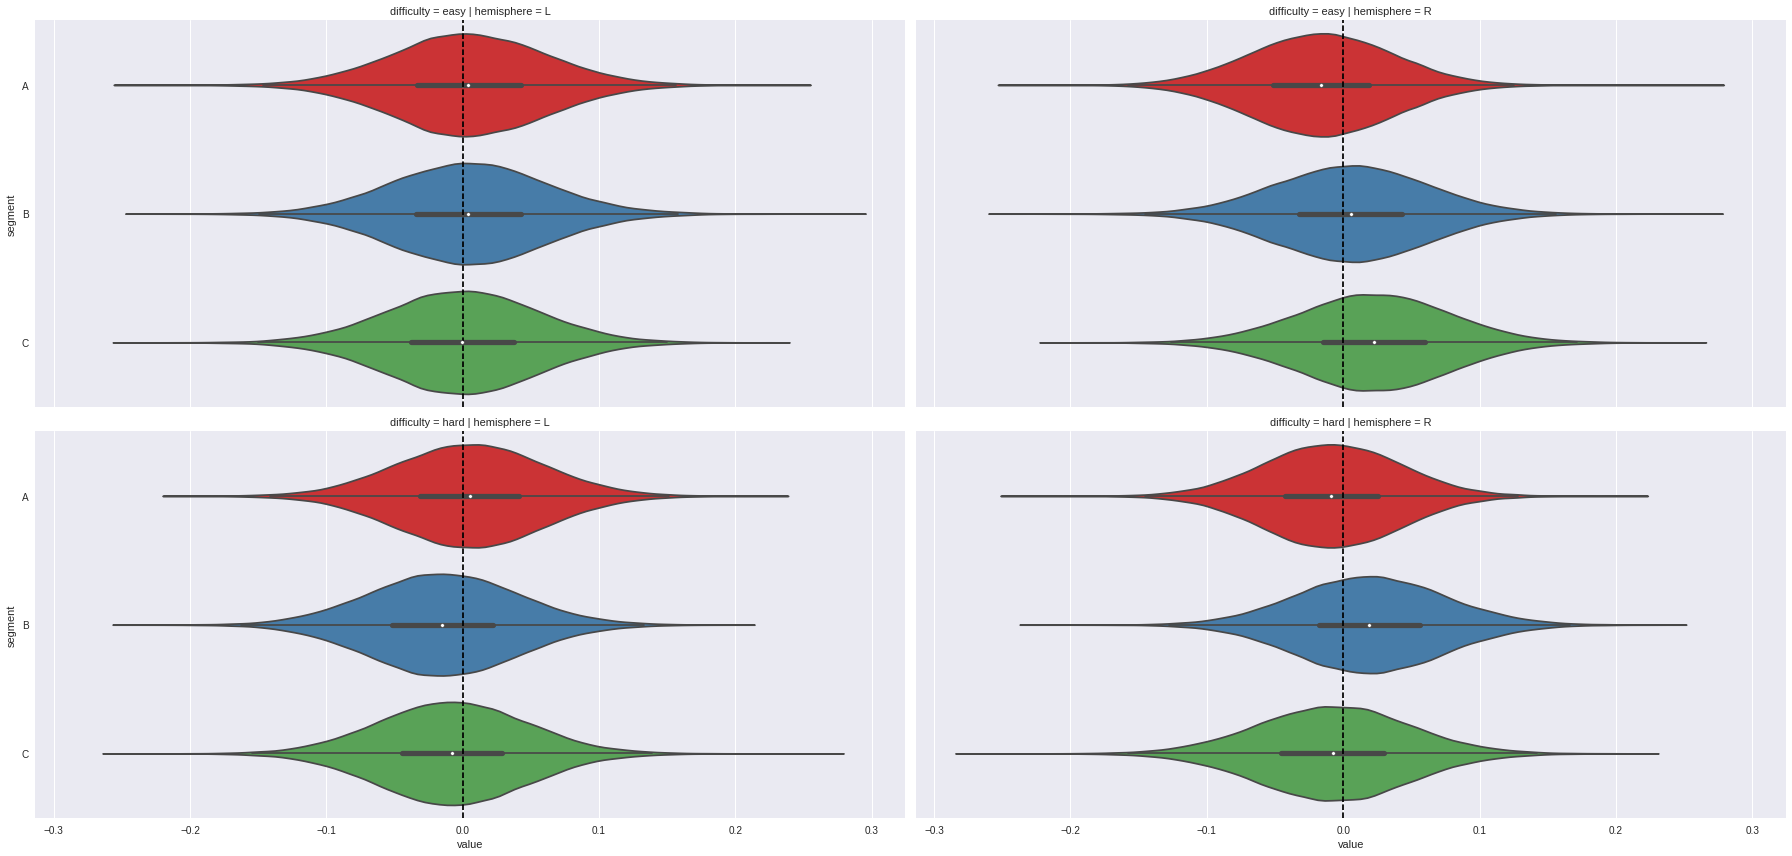

In [18]:
fac = sns.FacetGrid(df, col='hemisphere', row='difficulty')
fac.map(sns.violinplot, 'value', 'segment', palette='Set1')

for ax in fac.axes.ravel():
    ax.axvline(0, c='k', ls='--')
    

fac.fig.set_size_inches(25, 12)

plt.tight_layout()

In [19]:
results = []

for hemisphere in ['L', 'R']:
# for hemisphere in ['L']:
    hddm_model = get_model('final_super_model_drift_zscored_error_interaction', hemisphere)
    
    traces = hddm_model.get_traces()
    
    for segment in ['A', 'B', 'C']:
        tmp = pandas.DataFrame({'value':traces['v_STh_{hemisphere}_{segment}_stim'.format(**locals())],
                          'sample':traces.index,
                          'segment':segment,
                          'hemisphere':hemisphere, 
                          'difficulty':'easy'})
        
        results.append(tmp)
        
        tmp = pandas.DataFrame({'value':traces['v_STh_{hemisphere}_{segment}_stim'.format(**locals())] + traces['v_C(difficulty)[T.hard]:STh_{hemisphere}_{segment}_stim'.format(**locals())],
                  'segment':segment,
                   'sample':traces.index,                                
                  'hemisphere':hemisphere, 
                  'difficulty':'hard'})
        
        results.append(tmp)

Adding these covariates:
['z_cue_coding']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_STh_L_A_stim', 'v_C(difficulty)[T.hard]:STh_L_A_stim', 'v_STh_L_B_stim', 'v_C(difficulty)[T.hard]:STh_L_B_stim', 'v_STh_L_C_stim', 'v_C(difficulty)[T.hard]:STh_L_C_stim', 'v_cue_coding']
Adding these covariates:
['z_cue_coding']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_STh_R_A_stim', 'v_C(difficulty)[T.hard]:STh_R_A_stim', 'v_STh_R_B_stim', 'v_C(difficulty)[T.hard]:STh_R_B_stim', 'v_STh_R_C_stim', 'v_C(difficulty)[T.hard]:STh_R_C_stim', 'v_cue_coding']


In [20]:
df = pandas.concat(results, ignore_index=True)
df.groupby(['hemisphere', 'difficulty', 'segment']).apply(lambda x: (x.value > 0).mean())

hemisphere  difficulty  segment
L           easy        A          0.583417
                        B          0.523983
                        C          0.480100
            hard        A          0.447500
                        B          0.457467
                        C          0.453800
R           easy        A          0.328194
                        B          0.689750
                        C          0.675667
            hard        A          0.472861
                        B          0.487000
                        C          0.565250
dtype: float64

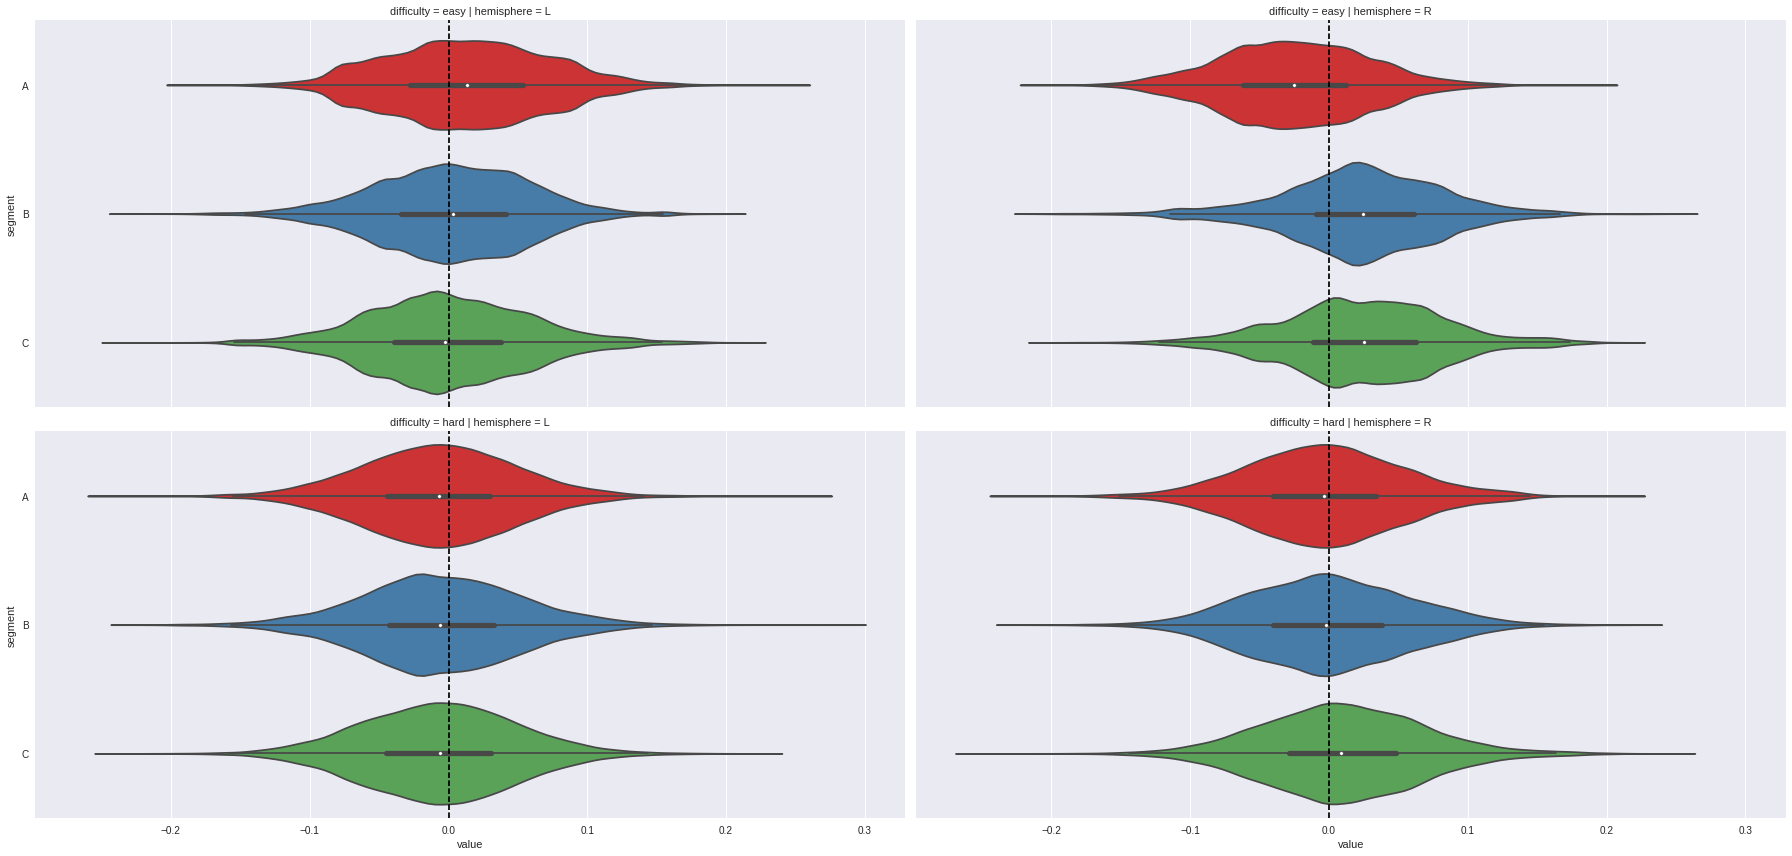

In [21]:
fac = sns.FacetGrid(df, col='hemisphere', row='difficulty')
fac.map(sns.violinplot, 'value', 'segment', palette='Set1')

for ax in fac.axes.ravel():
    ax.axvline(0, c='k', ls='--')
    

fac.fig.set_size_inches(25, 12)

plt.tight_layout()